In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Carga de la data

Text(0, 0.5, 'Sales')

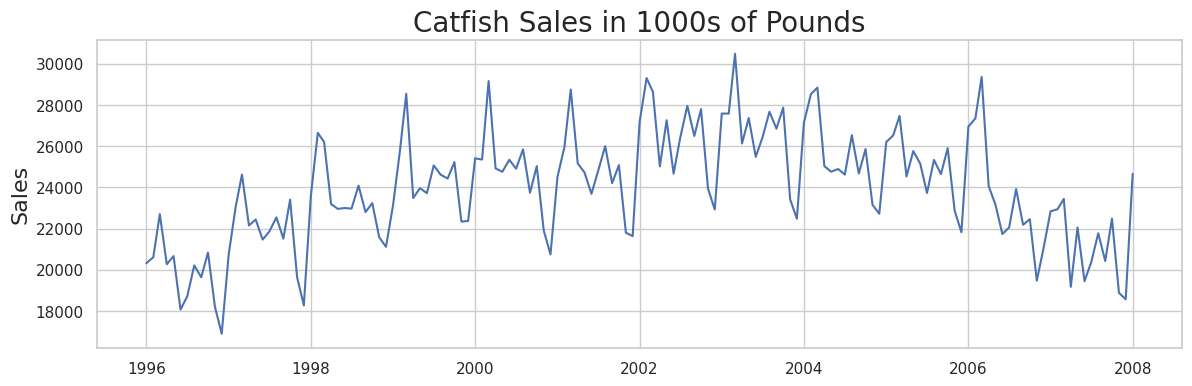

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
#read data
catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

#transform
start_date = datetime(1996,1,1)
end_date = datetime(2008,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

#plot
plt.figure(figsize=(14,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)

Se observa a primera vista una leve tendencia y estacionalidad. Se aplicará STL para descomponer estos elementos. 

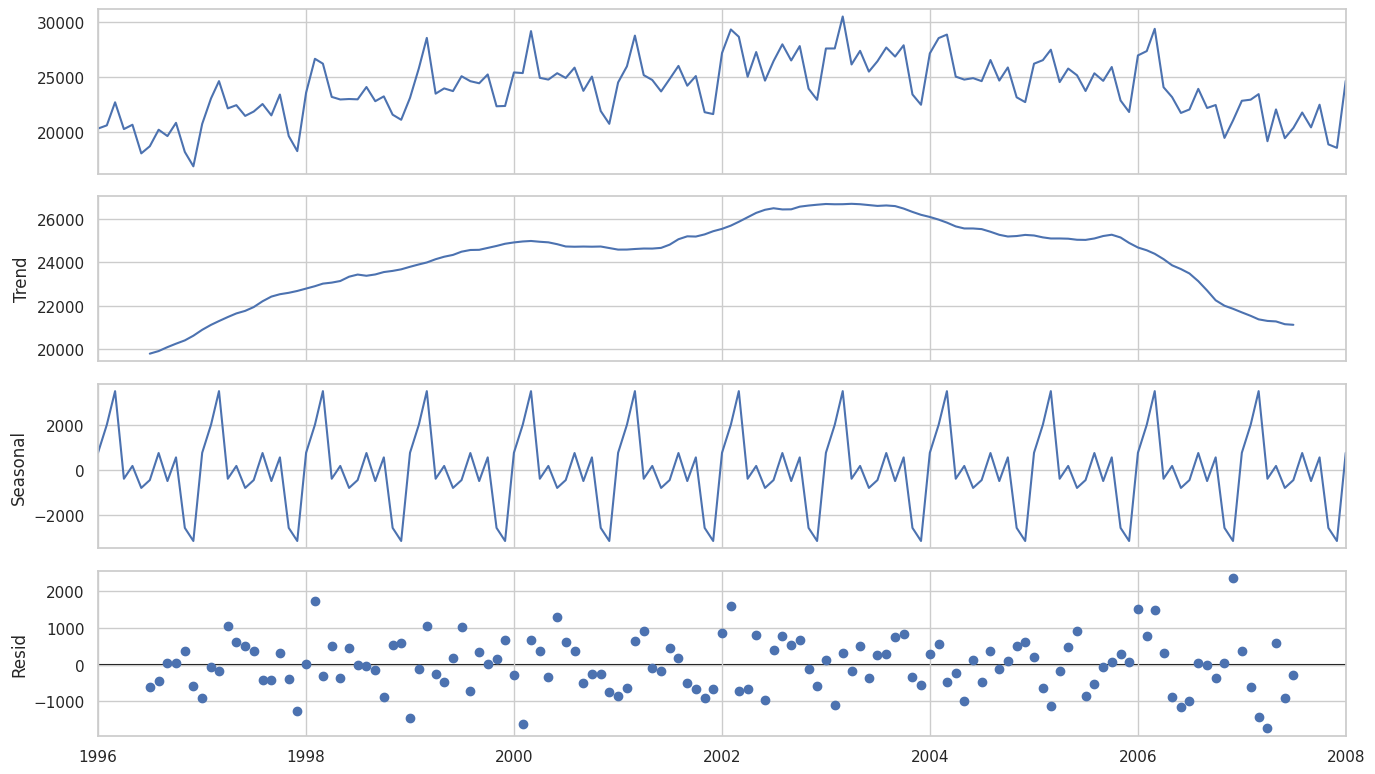

In [3]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales)
fig = result.plot()

Puntos a considerar:
    Se observa un patron estacional de 6 y 12 meses
    Una tendencia primero al alza y luego al descenso es observada. 

Otra forma de ver si la serie es estacionaria es mediante test estadisticos. Tenemos el test de Dickey-Fuller y otro....

In [4]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(lim_catfish_sales['Total'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.8796998671338676
ADF p-values: 0.34167036071480034
ADF number of lags used: 14
ADF number of observations: 130
ADF critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
ADF best information criterion: 2222.5244882802926


El p-value es > que 0.05 lo que se rechaza la hipotesis nula (la serie es stacionaria) y la serie es no estacionaria. Además la variable test statisc del test indica que es mayor que los valores criticos 1%(99%), 5%(95%) y 10%(90%) por tanto es indiscutible que con un 99% de confianza la serie es no estacionaria. 

Hagamosla estacionaria aplicando primero el método de las diferencias con una sola diferencia y probemos nuevamente el test. 

<Axes: xlabel='Date'>

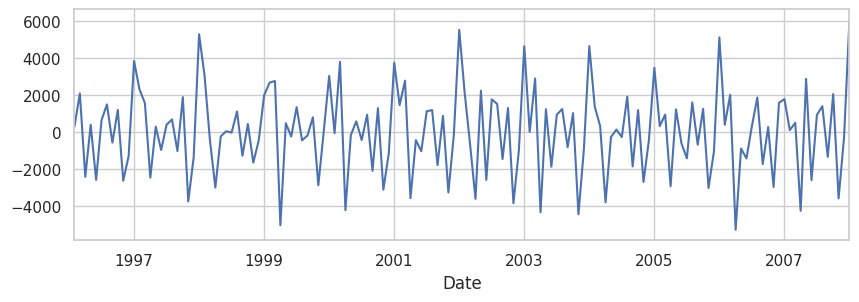

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
diff = lim_catfish_sales['Total'].diff()
diff = diff.dropna()
diff.plot()

In [6]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(diff)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -2.4204865752180056
ADF p-values: 0.13603750958461636
ADF number of lags used: 13
ADF number of observations: 130
ADF critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
ADF best information criterion: 2207.5690814776353


La serie sigue siendo no estacionaria por el factor estacional que no se le ha eliminado. Por tanto un modelo ARIMA solo no es conveniente sino un modelo SARIMA veamos las diferencias en estos modelos 

Familia de modelos ARIMA 

1. Autoregression (AR): Primer bloque de la familia ARIMA (parametro p)
El orden de un modelo AR es p,representa el numero de valores pasados a incluir en el modelo. El modelo más simple es es el AR(1): usa solo un valor anterior para predecir el valor actual. El número máximo de valores a usar es la longitud total de la serie. (i.e. usar toda la data).

2. Moving average (MA): Segundo bloque (parámetro q)
Este bloque no usa los valores reales anteriores sino el error de predicción en valores anteriores para predecir le valor futuro. Puede usar varios pasos de tiempo hacia atrás y se representa con el parámetro q. For example, un MA(1) tienen un orde = 1 y solo usa el error de predicción de un paso de tiempo haci atrás. 

3. Autoregressive moving average (ARMA): Combinación de bloques anteriores
El modelo ARMA, combina los modelos AR y MA en un mismo modelo. ARMA puede usar los valores anteriores y los errores en las predicciones del pasado. 
ARMA puede tener diferentes valores para los factores p y q de AR y MA. Ejemplo ARMA(1, 0) es un AR de orden 1 (p=1)  y MA de orden 0 (q=0). Que en verdad sería un modelo AR(1). Un modelo MA(1) es lo mismo que un ARMA(0, 1). Otras combinaciones posibles: ARMA(3, 1) tiene un AR de orden 3 (3 valores pasados) y usa el error de prediccion de un solo valor hacia atrás para el modelo MA.

4. Autoregressive integrated moving average (ARIMA) (p, d, q)
Es un modelo ARMA más un nuevo factor (d) llamado diferenciación, que es el número de veces que la serie necesita ser recalculada para hacerla estacionaria. 
Por ejemplo : un ARMA(1,1) que necesita solo una diferenciación se escribe: ARIMA(1, 1, 1). el primer  1 is para el orden del modelo AR, el segundo es para la diferenciación, y el 3ro es para el orden MA. ARIMA(1, 0, 1) es lo mismo que ARMA(1, 1).

5. Seasonal autoregressive integrated moving-average (SARIMA)
SARIMA agrega efectos estacionales al modelo ARIMA. Si existe estacionalidad en la serie hay que usarla en el modelo. Por ello se agregan un componente estacional dado por cuatro nuevos factores (P, D, Q)m.
m es el numero de observaciones en un año: datos mensuales tiene m=12, datos cuatrimestrales tiene m=4 etc. Las minusculas (p, d, q) representan el orden de los componentes no estacionales. Las mayusculas (P, D, Q) representa el orden de los componentes estacionales. 

<img align="Right" src="./images/Sarima-seasonality.webp"  style=" width:350px; padding: 10px 20px ; ">

6. Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects. On top of that, it adds the X: external variables. If you have any variables that could help your model to improve, you could add them with SARIMAX.





Veamos las graficas ACF y PACF plots para tener una idea de los valores p y q para los modelos ARIMA

In [7]:
lim_catfish_sales.columns

Index(['Total'], dtype='object')

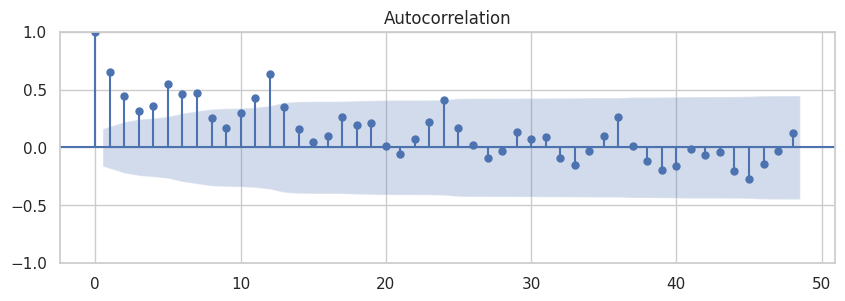

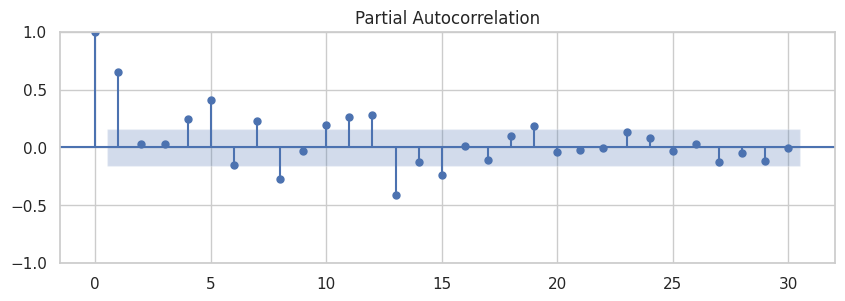

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(lim_catfish_sales['Total'], ax = ax1,  lags=48);
fig, ax2 = plt.subplots(1, 1, figsize=(10, 3))
plot_pacf(lim_catfish_sales['Total'], ax = ax2, lags=30);

Existe picos significativos al 6to y 12vo mes en la ACF, el PACF muestra el pico interesante en el 6to mes y en el mes 12. P puede ser testeado con los valores 6 y 12 en el SARIMA 

# ARIMA

In [9]:
arima = ARIMA(lim_catfish_sales['Total'], order=(12,1,1))
predictions_arima = arima.fit().predict()

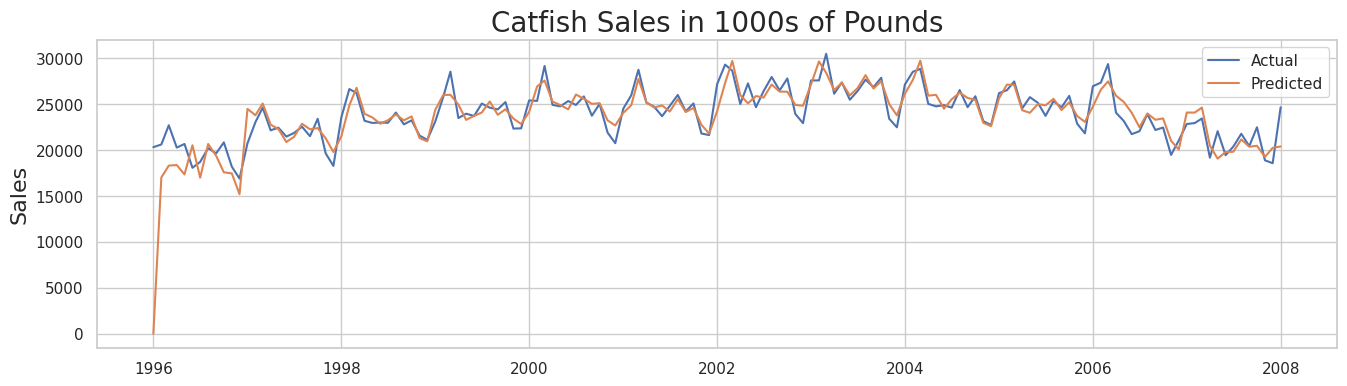

In [10]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales['Total'], label="Actual")
plt.plot(predictions_arima, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

# SARIMA

In [11]:
sarima = SARIMAX(lim_catfish_sales['Total'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82528D+00    |proj g|=  2.22856D-01

At iterate    5    f=  7.73485D+00    |proj g|=  5.30062D-02


 This problem is unconstrained.



At iterate   10    f=  7.67575D+00    |proj g|=  2.64864D-02

At iterate   15    f=  7.67492D+00    |proj g|=  6.63458D-04

At iterate   20    f=  7.67472D+00    |proj g|=  1.52639D-02

At iterate   25    f=  7.65970D+00    |proj g|=  1.07347D-01

At iterate   30    f=  7.65017D+00    |proj g|=  3.34778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     39      1     0     0   1.598D-06   7.650D+00
  F =   7.6501707265147534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


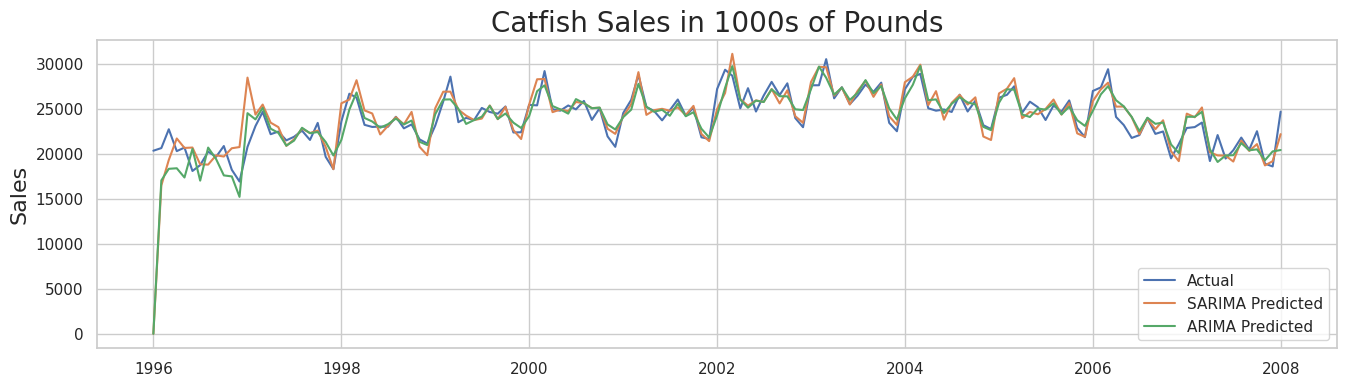

In [12]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales, label="Actual")
plt.plot(predictions, label="SARIMA Predicted")
plt.plot(predictions_arima, label="ARIMA Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

# Experimentos

El SARIMA es el mejorcito a simple vista vamos a entrenar y evaluar con varios modelos haciendo tuning a los hiperparámetros. 

# Preparando conjuntos de train y test

Se pican conjuntos test desde 1996 - 2005 y conjunto de prueba desde 2006-2008

In [13]:
#prepare train and test sets

train_start_date = datetime(1996,1,1)
train_end_date = datetime(2005,12,31)
train = catfish_sales[train_start_date:train_end_date]

test_start_date = datetime(2006,1,1)
test_end_date = datetime(2008,1,1)
test = catfish_sales[test_start_date:test_end_date]

train.shape, test.shape


((120, 1), (25, 1))

# Entrenamiento 

In [14]:
sarima = SARIMAX(train['Total'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
model = sarima.fit()

# Haciendo predicciones
n_periods = 25  # número de períodos a predecir, ajusta a tus necesidades
forecast = model.get_forecast(steps=n_periods)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62864D+00    |proj g|=  3.31133D-01

At iterate    5    f=  7.52827D+00    |proj g|=  2.06414D-02


 This problem is unconstrained.



At iterate   10    f=  7.47257D+00    |proj g|=  2.15667D-01

At iterate   15    f=  7.42974D+00    |proj g|=  5.94780D-04

At iterate   20    f=  7.42973D+00    |proj g|=  2.03722D-03

At iterate   25    f=  7.42826D+00    |proj g|=  2.45211D-02

At iterate   30    f=  7.41588D+00    |proj g|=  8.51377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     43      1     0     0   1.866D-06   7.416D+00
  F =   7.4157008017009636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


# Predicciones 

In [15]:
# Convertir las predicciones a un dataframe para facilitar la manipulación o visualización
forecast_df = pd.DataFrame({
    'predicted_mean': forecast_mean,
    'lower_ci': confidence_intervals.iloc[:, 0],
    'upper_ci': confidence_intervals.iloc[:, 1]
})


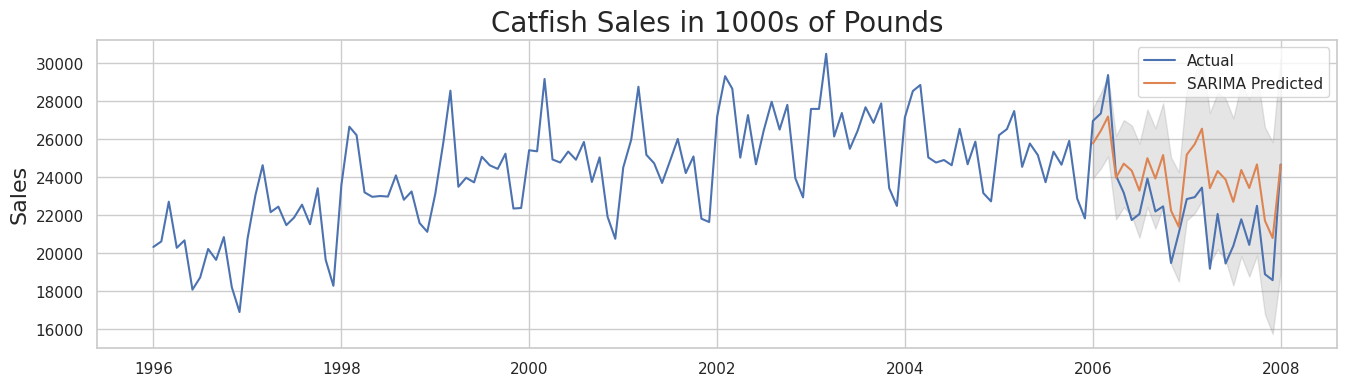

In [16]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales, label="Actual")
plt.plot(forecast_df['predicted_mean'], label="SARIMA Predicted")
# Área de intervalo de confianza
plt.fill_between(forecast_df.index,
                 forecast_df['lower_ci'],
                 forecast_df['upper_ci'], 
                 color='gray', alpha=0.2)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [17]:
np.sqrt(mean_squared_error(test['Total'], forecast_df['predicted_mean'])), mean_absolute_error(test['Total'], forecast_df['predicted_mean'])

(2373.7376316388945, 2104.556571118564)

# Preparando el entorno de experimento con MLFlow

In [18]:
# Model experimentation library
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient



In [19]:
# Initialize MLflow

experiment_name = "catfish_forcast_experiments_v1"
artifact_repository = './mlflow-run'

# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Initialize MLflow client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Tuning hiperparametros
Vamos a hacer tuning con los parametros no estacionales (p,d,q) solamente 
Haremos un crosvalidation, evaluamos el conjunto de prueba con metricas RMSE, MAE, AGREGAR OTRAS...

In [31]:
run_name = 'SARIMA_model'

param_list_mlflow = [({"p":x, "d":y, "q": z}) for x in range(3) for y in range(3) for z in range(3)]
param_list = [(x, y,  z) for x in range(3) for y in range(3) for z in range(3)]


for mlflow_params, non_seasonal_order in zip( param_list_mlflow, param_list): 

    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
       
       #get params of experiment
            mlflow.log_params(mlflow_params)
       
        # Get run id 
            run_id = run.info.run_uuid
        
        # Provide brief notes about the run
            MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This is experiment for exploring different machine learning models for Campus Recruitment Dataset")

        # To enable autologging for scikit-learn estimators.
        # 1) Log estimator parameters
        # 2) Log common metrics for classifier
        # 3) Log model Artifacts
            mlflow.sklearn.autolog()

        # Define custom tag
            tags = {"Application": "Payment Monitoring Platform",
                "release.candidate": "PMP",
                "release.version": "2.2.0"}
        
        # Set Tag
            mlflow.set_tags(tags)
                        
        # Log python environment details
            mlflow.log_artifact('requirements.txt')

            # for each param combi do a ts split
            # 25 months test size
            mses = []
            maes = []
            rmses = []

            # Define el número de splits
            tscv = TimeSeriesSplit(n_splits=3, test_size=25)
          
            # Itera sobre los splits
            for train_cv_index, val_cv_index in tscv.split(train):
              
                try:
                 
                  train_cv = train.iloc[train_cv_index]
                  val_cv = train.iloc[val_cv_index]
                 

                  # for each ts split do a model
                  sarima = SARIMAX(train_cv['Total'],
                        order = non_seasonal_order,
                        seasonal_order=(1,1,0,12))
                  
                  model = sarima.fit() 

         
                  pred = model.forecast(25).values

                  mse = mean_squared_error(val_cv['Total'], pred)
                  mses.append(mse)
                  
                  rmse = np.sqrt(mse)
                  rmses.append(rmse)

                  mae = mean_absolute_error(val_cv['Total'], pred)
                  maes.append(mae)



                except Exception as e:
              # ignore models that error
                  print("Error",str( e))
                  pass
            
            average_rmse = np.mean(rmses)
            std_rmse = np.std(rmses) 

             # log metrics
            mlflow.log_metrics({"RMSE train": average_rmse})
            mlflow.log_metrics({"std RMSE train": std_rmse})
            
            # evaluation in test set
            pred = model.forecast(25).values

            mse = mean_squared_error(val_cv['Total'], pred)                   
            rmse = np.sqrt(mse)           

            mae = mean_absolute_error(val_cv['Total'], pred)          

            mlflow.end_run()




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71776D+00    |proj g|=  6.58137D+00

At iterate    5    f=  6.29905D+00    |proj g|=  7.56136D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   7.561D-05   6.299D+00
  F =   6.2990538223346091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.52945D+00    |proj g|=  2.49532D-03

At iterate   10    f=  7.52932D+00    |proj g|=  5.23224D-02

At iterate   15    f=  7.52715D+00    |proj g|=  2.15666D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     24      1     0     0   3.879D-06   7.527D+00
  F =   7.5271229472088876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39242D+00    |proj g|=  3.36084D+00

At iterate    5    f=  6.37064D+00    |proj g|=  5.49244D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   2.052D-04   6.370D+00
  F =   6.3704682244646609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.51466D+00    |proj g|=  6.90458D-02

At iterate   10    f=  7.51439D+00    |proj g|=  4.33912D-03

At iterate   15    f=  7.51338D+00    |proj g|=  8.48639D-02

At iterate   20    f=  7.49610D+00    |proj g|=  7.05195D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   6.383D-06   7.495D+00
  F =   7.4954574033943633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.07207D+00    |proj g|=  6.37695D-02

At iterate   10    f=  7.07116D+00    |proj g|=  1.82129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.821D-04   7.071D+00
  F =   7.0711634688343530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55562D+00    |proj g|=  7.85514D-01

At iterate    5    f=  7.50931D+00    |proj g|=  7.25488D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  7.49754D+00    |proj g|=  2.06989D-01

At iterate   25    f=  7.49530D+00    |proj g|=  1.57921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   1.143D-05   7.495D+00
  F =   7.4953032554641030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30572D+00    |proj g|=  5.19429D-01

At iterate    5    f=  6.09611D+00    |proj g|=  8.93301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   8.933D-05   6.096D+00
  F =   6.0961137291192991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19720D+00    |proj g|=  4.97292D-01

At iterate    5    f=  5.95978D+00    |proj g|=  2.02243D-03

At iterate   10    f=  5.95978D+00    |proj g|=  1.82293D-03

At iterate   15    f=  5.95952D+00    |proj g|=  2.48164D-02

At iterate   20    f=  5.94492D+00    |proj g|=  1.10693D-01

At iterate   25    f=  5.93852D+00    |proj g|=  8.13316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23663D+00    |proj g|=  8.84527D-02

At iterate    5    f=  7.23243D+00    |proj g|=  3.01955D-04

At iterate   10    f=  7.23220D+00    |proj g|=  1.99737D-02

At iterate   15    f=  7.21670D+00    |proj g|=  1.28820D-01


 This problem is unconstrained.



At iterate   20    f=  7.20811D+00    |proj g|=  2.78018D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   2.780D-06   7.208D+00
  F =   7.2081115917438172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30877D+00    |proj g|=  5.91145D-01

At iterate    5    f=  5.96716D+00    |proj g|=  1.41481D-03

At iterate   10    f=  5.96716D+00    |proj g|=  1.38357D-03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19268D+00    |proj g|=  4.28522D-01

At iterate    5    f=  7.06230D+00    |proj g|=  1.21489D-02


 This problem is unconstrained.



At iterate   10    f=  6.79358D+00    |proj g|=  3.04171D-01

At iterate   15    f=  6.75318D+00    |proj g|=  2.07547D-04

At iterate   20    f=  6.75317D+00    |proj g|=  3.73434D-03

At iterate   25    f=  6.75193D+00    |proj g|=  4.38078D-02

At iterate   30    f=  6.73361D+00    |proj g|=  2.83461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     43      1     0     0   1.435D-06   6.733D+00
  F =   6.7328579690373029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.22095D+00    |proj g|=  1.77159D-04

At iterate   15    f=  7.22094D+00    |proj g|=  1.98322D-03

At iterate   20    f=  7.21950D+00    |proj g|=  2.44869D-02

At iterate   25    f=  7.20638D+00    |proj g|=  3.08927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   5.733D-06   7.206D+00
  F =   7.2063689639621558     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71882D+00    |proj g|=  1.49561D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   3.271D-05   7.708D+00
  F =   7.7079261414237932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.90895D+00    |proj g|=  4.65659D-05

At iterate   15    f=  6.90893D+00    |proj g|=  5.13987D-04

At iterate   20    f=  6.90771D+00    |proj g|=  1.22319D-02

At iterate   25    f=  6.90714D+00    |proj g|=  1.24902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   2.498D-05   6.907D+00
  F =   6.9071388036860863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86287D+00    |proj g|=  9.41557D-01

At iterate    5    f=  6.04830D+00    |proj g|=  3.54957D-02

At iterate   10    f=  6.04650D+00    |proj g|=  3.29335D-03

At iterate   15    f=  6.04648D+00    |proj g|=  1.56245D-04

At iterate   20    f=  6.04648D+00    |proj g|=  2.64259D-03

At iterate   25    f=  6.04554D+00    |proj g|=  2.95396D-02

At iterate   30    f=  6.03806D+00    |proj g|=  4.12723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  6.90787D+00    |proj g|=  4.07711D-04

At iterate   20    f=  6.90785D+00    |proj g|=  5.42097D-03

At iterate   25    f=  6.90523D+00    |proj g|=  4.30855D-02

At iterate   30    f=  6.90104D+00    |proj g|=  2.21356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     36      1     0     0   9.697D-06   6.901D+00
  F =   6.9010041919441258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  7.35564D+00    |proj g|=  1.07719D-02

At iterate   30    f=  7.35555D+00    |proj g|=  7.86847D-04

At iterate   35    f=  7.35333D+00    |proj g|=  2.50347D-02

At iterate   40    f=  7.35279D+00    |proj g|=  5.52713D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     52      1     0     0   5.527D-07   7.353D+00
  F =   7.3527850635343910     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.48742D+00    |proj g|=  3.00390D+00

At iterate   10    f=  6.29389D+00    |proj g|=  6.22942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.706D-05   6.294D+00
  F =   6.2938118063539754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89093D+00    |proj g|=  1.96768D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.12890D+00    |proj g|=  1.50284D+00

At iterate   10    f=  7.04663D+00    |proj g|=  1.91321D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   1.913D-05   7.047D+00
  F =   7.0466329560692520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85538D+00    |proj g|=  1.26648D+00

At iterate    5    f=  7.51859D+00    |proj g|=  4.86666D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11151D+00    |proj g|=  2.72437D+00

At iterate    5    f=  6.98503D+00    |proj g|=  4.25401D-01

At iterate   10    f=  6.40573D+00    |proj g|=  2.58490D+00

At iterate   15    f=  6.27990D+00    |proj g|=  8.77494D-03

At iterate   20    f=  6.27828D+00    |proj g|=  7.92097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.001D-05   6.278D+00
  F =   6.2782791514124332     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.78374D+00    |proj g|=  3.52842D-01

At iterate   10    f=  7.09921D+00    |proj g|=  9.92748D-01

At iterate   15    f=  7.06028D+00    |proj g|=  7.74928D-03

At iterate   20    f=  7.05840D+00    |proj g|=  6.01401D-02

At iterate   25    f=  7.05647D+00    |proj g|=  1.66011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.984D-04   7.056D+00
  F =   7.0564723723864979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.36225D+00    |proj g|=  3.46227D-01

At iterate   15    f=  7.34077D+00    |proj g|=  1.42537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   9.594D-05   7.341D+00
  F =   7.3407717941730040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03130D+00    |proj g|=  6.30537D+00

At iterate    5    f=  6.45142D+00    |proj g|=  5.72087D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  6.10825D+00    |proj g|=  4.91393D-01

At iterate   20    f=  6.06213D+00    |proj g|=  2.75382D-01

At iterate   25    f=  6.04772D+00    |proj g|=  2.52117D-03

At iterate   30    f=  6.04772D+00    |proj g|=  8.61191D-04

At iterate   35    f=  6.04771D+00    |proj g|=  2.04346D-02

At iterate   40    f=  6.04663D+00    |proj g|=  5.01093D-02

At iterate   45    f=  6.03183D+00    |proj g|=  1.38758D-01

At iterate   50    f=  6.03019D+00    |proj g|=  4.42641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   4.426D-04   6.030D+00
  F =   6.03019341766

 This problem is unconstrained.



At iterate   20    f=  6.83407D+00    |proj g|=  3.09864D-03

At iterate   25    f=  6.83382D+00    |proj g|=  4.51770D-02

At iterate   30    f=  6.83076D+00    |proj g|=  8.24250D-02

At iterate   35    f=  6.83033D+00    |proj g|=  3.04258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     41      1     0     0   3.278D-04   6.830D+00
  F =   6.8303258883471178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.34331D+00    |proj g|=  1.88550D-01

At iterate   15    f=  7.33855D+00    |proj g|=  1.16948D-01

At iterate   20    f=  7.33613D+00    |proj g|=  9.41504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   5.891D-05   7.336D+00
  F =   7.3361317952721947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19188D+00    |proj g|=  5.22207D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  5.99856D+00    |proj g|=  5.20559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   9.116D-06   5.999D+00
  F =   5.9985430779522835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82918D+00    |proj g|=  1.51242D-01

At iterate    5    f=  6.81955D+00    |proj g|=  1.38454D-04

At iterate   10    f=  6.81950D+00    |proj g|=  8.05025D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  6.81070D+00    |proj g|=  2.93470D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   7.467D-07   6.811D+00
  F =   6.8106986955251294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29870D+00    |proj g|=  9.46248D-02

At iterate    5    f=  7.29439D+00    |proj g|=  1.19928D-04

At iterate   10    f=  7.29439D+00    |proj g|=  2.26224D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  7.28737D+00    |proj g|=  5.26639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   7.550D-06   7.287D+00
  F =   7.2873370692725006     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60950D+00    |proj g|=  1.02003D+00

At iterate    5    f=  5.95278D+00    |proj g|=  1.02415D-03

At iterate   10    f=  5.95277D+00    |proj g|=  1.69083D-04

At iterate   15    f=  5.95276D+00    |proj g|=  3.58616D-03

At iterate   20    f=  5.95156D+00    |proj g|=  3.95062D-02

At iterate   25    f=  5.94008D+00    |proj g|=  3.37062D-02

At iterate   30    f=  5.93830D+00    |proj g|=  4.60808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    0    f=  6.86943D+00    |proj g|=  2.69905D-01

At iterate    5    f=  6.75680D+00    |proj g|=  5.23414D-02

At iterate   10    f=  6.75447D+00    |proj g|=  2.11875D-04

At iterate   15    f=  6.75437D+00    |proj g|=  9.44391D-03

At iterate   20    f=  6.74609D+00    |proj g|=  7.89427D-02

At iterate   25    f=  6.73286D+00    |proj g|=  5.11259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   4.966D-07   6.733D+00
  F =   6.7328609571850055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  7.22944D+00    |proj g|=  4.81029D-04

At iterate   15    f=  7.22886D+00    |proj g|=  9.40148D-03

At iterate   20    f=  7.20883D+00    |proj g|=  2.59836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     26      1     0     0   9.222D-06   7.207D+00
  F =   7.2071166016559767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51622D+00    |proj g|=  5.82926D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  5.95623D+00    |proj g|=  2.49077D-02

At iterate   30    f=  5.93636D+00    |proj g|=  4.72732D-02

At iterate   35    f=  5.92024D+00    |proj g|=  3.21230D-02

At iterate   40    f=  5.91902D+00    |proj g|=  2.09093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     54      1     0     0   8.543D-06   5.919D+00
  F =   5.9189550043483372     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  6.74595D+00    |proj g|=  5.52088D-03

At iterate   20    f=  6.74493D+00    |proj g|=  4.03488D-02

At iterate   25    f=  6.73445D+00    |proj g|=  9.21193D-02

At iterate   30    f=  6.72979D+00    |proj g|=  2.82353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   5.842D-06   6.730D+00
  F =   6.7297946572661953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.21199D+00    |proj g|=  1.13926D-03

At iterate   10    f=  7.21193D+00    |proj g|=  4.13250D-04

At iterate   15    f=  7.21192D+00    |proj g|=  8.98236D-04

At iterate   20    f=  7.21173D+00    |proj g|=  1.02416D-02

At iterate   25    f=  7.20716D+00    |proj g|=  1.22322D-02

At iterate   30    f=  7.19994D+00    |proj g|=  2.73826D-02

At iterate   35    f=  7.19913D+00    |proj g|=  1.55092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   8.162D-07   7.199D+00
  F =   7.1991251151259572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45210D+00    |proj g|=  2.83105D-01

At iterate    5    f=  6.14143D+00    |proj g|=  5.12517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   5.125D-05   6.140D+00
  F =   6.1402518936828452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.56905D+00    |proj g|=  5.88717D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   5.887D-05   7.569D+00
  F =   7.5690457766309294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30400D+00    |proj g|=  1.30109D+00

At iterate    5    f=  6.05334D+00    |proj g|=  1.03635D-01

At iterate   10    f=  6.04360D+00    |proj g|=  1.68782D-03

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34929D+00    |proj g|=  9.90240D-01

At iterate    5    f=  6.92192D+00    |proj g|=  4.67239D-02

At iterate   10    f=  6.90587D+00    |proj g|=  2.67320D-03

At iterate   15    f=  6.90576D+00    |proj g|=  7.41681D-05


 This problem is unconstrained.



At iterate   20    f=  6.90575D+00    |proj g|=  3.19072D-03

At iterate   25    f=  6.90439D+00    |proj g|=  2.11066D-02

At iterate   30    f=  6.90292D+00    |proj g|=  3.83888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     35      1     0     0   7.230D-06   6.903D+00
  F =   6.9029049365900246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80633D+00    |proj g|=  8.94487D-01


 This problem is unconstrained.



At iterate    5    f=  7.39069D+00    |proj g|=  4.50399D-02

At iterate   10    f=  7.37680D+00    |proj g|=  2.66686D-03

At iterate   15    f=  7.37670D+00    |proj g|=  5.72664D-04

At iterate   20    f=  7.37589D+00    |proj g|=  3.28254D-03

At iterate   25    f=  7.36166D+00    |proj g|=  1.60496D-04

At iterate   30    f=  7.36165D+00    |proj g|=  3.09938D-03
  ys=-1.683E-04  -gs= 6.963E-05 BFGS update SKIPPED

At iterate   35    f=  7.36004D+00    |proj g|=  3.02117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     50      1     1     0   6.875D-06   7.360D+00
  F =   7.3600363305352223     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53100D+00    |proj g|=  5.52034D-01

At iterate    5    f=  6.05536D+00    |proj g|=  2.73553D-02

At iterate   10    f=  6.04181D+00    |proj g|=  1.21332D-03

At iterate   15    f=  6.04153D+00    |proj g|=  6.30741D-03

At iterate   20    f=  6.04130D+00    |proj g|=  5.92459D-05

At iterate   25    f=  6.04130D+00    |proj g|=  1.40926D-03

At iterate   30    f=  6.04097D+00    |proj g|=  6.44736D-03

At iterate   35    f=  6.03798D+00    |proj g|=  2.76154D-03

At iterate   40    f=  6.03767D+00    |proj g|=  3.12214D-03

At iterate   45    f=  6.03761D+00    |proj g|=  2.15693D-03

At iterate   50    f=  6.03760D+00    |proj g|=  3.31680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  6.91042D+00    |proj g|=  1.82073D-03

At iterate   20    f=  6.90703D+00    |proj g|=  1.25873D-02

At iterate   25    f=  6.90624D+00    |proj g|=  2.16428D-04

At iterate   30    f=  6.90616D+00    |proj g|=  4.83647D-04

At iterate   35    f=  6.90207D+00    |proj g|=  7.33603D-04

At iterate   40    f=  6.90202D+00    |proj g|=  4.38449D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     52      1     0     0   4.384D-06   6.902D+00
  F =   6.9020157459532454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  7.37173D+00    |proj g|=  1.47384D-04

At iterate   15    f=  7.37173D+00    |proj g|=  1.46286D-04

At iterate   20    f=  7.37165D+00    |proj g|=  3.17694D-03

At iterate   25    f=  7.36658D+00    |proj g|=  5.63003D-02

At iterate   30    f=  7.35501D+00    |proj g|=  1.50319D-02

At iterate   35    f=  7.35391D+00    |proj g|=  6.13678D-03

At iterate   40    f=  7.35377D+00    |proj g|=  9.63921D-04

At iterate   45    f=  7.35330D+00    |proj g|=  9.15891D-03

At iterate   50    f=  7.34731D+00    |proj g|=  3.48882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.05938D+00    |proj g|=  2.61320D-01

At iterate   10    f=  7.04864D+00    |proj g|=  1.14845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     17      1     0     0   1.148D-04   7.049D+00
  F =   7.0486409466783577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02273D+00    |proj g|=  1.49650D+00


 This problem is unconstrained.



At iterate    5    f=  7.53069D+00    |proj g|=  7.71137D-01

At iterate   10    f=  7.50423D+00    |proj g|=  1.18039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   1.468D-04   7.504D+00
  F =   7.5042227267299841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64613D+00    |proj g|=  7.12037D+00

At iterate    5    f=  6.29006D+00    |proj g|=  3.75231D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  6.28362D+00    |proj g|=  2.46995D-01

At iterate   20    f=  6.27878D+00    |proj g|=  1.01128D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.329D-03   6.279D+00
  F =   6.2787685214905347     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18000D+00    |proj g|=  1.87829D+00


 This problem is unconstrained.



At iterate    5    f=  7.06854D+00    |proj g|=  1.76679D-02

At iterate   10    f=  7.06846D+00    |proj g|=  9.69285D-03

At iterate   15    f=  7.06801D+00    |proj g|=  7.17503D-02

At iterate   20    f=  7.06755D+00    |proj g|=  4.92224D-04

At iterate   25    f=  7.06746D+00    |proj g|=  1.63787D-02

At iterate   30    f=  7.05990D+00    |proj g|=  7.30212D-02

At iterate   35    f=  7.04317D+00    |proj g|=  9.05164D-03

At iterate   40    f=  7.04203D+00    |proj g|=  6.62033D-03

At iterate   45    f=  7.03723D+00    |proj g|=  2.23504D-02

At iterate   50    f=  7.03458D+00    |proj g|=  1.16355D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  7.52043D+00    |proj g|=  1.29140D-03

At iterate   20    f=  7.52042D+00    |proj g|=  1.40621D-03

At iterate   25    f=  7.52020D+00    |proj g|=  1.83536D-02

At iterate   30    f=  7.51591D+00    |proj g|=  1.46154D-01

At iterate   35    f=  7.49691D+00    |proj g|=  4.49397D-02

At iterate   40    f=  7.49490D+00    |proj g|=  1.53628D-01

At iterate   45    f=  7.49163D+00    |proj g|=  1.45488D-02

At iterate   50    f=  7.49113D+00    |proj g|=  6.74957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   6.750D-02   7.491D+00
  F =   7.49112853359

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12939D+00    |proj g|=  7.66829D+00

At iterate    5    f=  6.36131D+00    |proj g|=  2.97534D+00

At iterate   10    f=  6.12969D+00    |proj g|=  3.52482D-01

At iterate   15    f=  6.08028D+00    |proj g|=  4.88915D-02

At iterate   20    f=  6.08006D+00    |proj g|=  1.16618D-02

At iterate   25    f=  6.08003D+00    |proj g|=  3.04470D-03

At iterate   30    f=  6.07980D+00    |proj g|=  7.18667D-02

At iterate   35    f=  6.07504D+00    |proj g|=  2.38478D-01

At iterate   40    f=  6.03902D+00    |proj g|=  3.55731D-01

At iterate   45    f=  6.00552D+00    |proj g|=  1.15371D-01

At iterate   50    f=  6.00442D+00    |proj g|=  7.75305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  6.84678D+00    |proj g|=  5.85633D-04

At iterate   20    f=  6.84678D+00    |proj g|=  6.97296D-03

At iterate   25    f=  6.84648D+00    |proj g|=  2.28124D-02

At iterate   30    f=  6.84028D+00    |proj g|=  2.63453D-01

At iterate   35    f=  6.80715D+00    |proj g|=  1.44157D-01

At iterate   40    f=  6.80407D+00    |proj g|=  1.10726D-02

At iterate   45    f=  6.80404D+00    |proj g|=  1.38423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     58      1     0     0   1.384D-04   6.804D+00
  F =   6.8040375149134125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.34361D+00    |proj g|=  2.21276D-01

At iterate   10    f=  7.33279D+00    |proj g|=  1.75847D-02

At iterate   15    f=  7.33252D+00    |proj g|=  3.08045D-03

At iterate   20    f=  7.33207D+00    |proj g|=  5.16440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   2.617D-04   7.332D+00
  F =   7.3320630102481656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16721D+00    |proj g|=  5.78164D-01

At iterate    5    f=  5.94200D+00    |proj g|=  9.53981D-04

At iterate   10    f=  5.94200D+00    |proj g|=  1.10988D-03

At iterate   15    f=  5.94190D+00    |proj g|=  1.51157D-02

At iterate   20    f=  5.93571D+00    |proj g|=  8.63135D-02

At iterate   25    f=  5.93171D+00    |proj g|=  1.68247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75571D+00    |proj g|=  1.34917D-01

At iterate    5    f=  6.73860D+00    |proj g|=  1.73528D-04

At iterate   10    f=  6.73859D+00    |proj g|=  4.33948D-03

At iterate   15    f=  6.73661D+00    |proj g|=  4.78252D-02

At iterate   20    f=  6.72738D+00    |proj g|=  3.46883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   5.683D-07   6.727D+00
  F =   6.7273614892918907     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  7.20825D+00    |proj g|=  3.57195D-02

At iterate   20    f=  7.19999D+00    |proj g|=  7.31181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   4.976D-06   7.200D+00
  F =   7.1999430971712792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27643D+00    |proj g|=  5.60473D-01

At iterate    5    f=  5.94096D+00    |proj g|=  4.12530D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  5.92675D+00    |proj g|=  7.14134D-02

At iterate   30    f=  5.91827D+00    |proj g|=  8.06090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   3.047D-06   5.918D+00
  F =   5.9182635786819651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76611D+00    |proj g|=  1.61664D-01


 This problem is unconstrained.



At iterate    5    f=  6.73288D+00    |proj g|=  2.47748D-02

At iterate   10    f=  6.73178D+00    |proj g|=  1.93281D-04

At iterate   15    f=  6.73174D+00    |proj g|=  6.01242D-03

At iterate   20    f=  6.72739D+00    |proj g|=  6.77036D-02

At iterate   25    f=  6.71545D+00    |proj g|=  2.83005D-03

At iterate   30    f=  6.71540D+00    |proj g|=  8.08296D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   8.083D-06   6.715D+00
  F =   6.7153973565553482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  7.20415D+00    |proj g|=  4.31599D-03

At iterate   10    f=  7.20401D+00    |proj g|=  1.80828D-04

At iterate   15    f=  7.20400D+00    |proj g|=  3.07259D-03

At iterate   20    f=  7.20333D+00    |proj g|=  3.64899D-02

At iterate   25    f=  7.18978D+00    |proj g|=  3.23373D-02

At iterate   30    f=  7.18867D+00    |proj g|=  9.95235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     34      1     0     0   6.947D-06   7.189D+00
  F =   7.1886708230982750     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  5.92952D+00    |proj g|=  1.59347D-03

At iterate   25    f=  5.92901D+00    |proj g|=  2.54397D-02

At iterate   30    f=  5.91810D+00    |proj g|=  3.39663D-02

At iterate   35    f=  5.91650D+00    |proj g|=  2.92195D-03

At iterate   40    f=  5.91648D+00    |proj g|=  5.28768D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     42      1     0     0   5.288D-06   5.916D+00
  F =   5.9164758483106068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f=  6.72991D+00    |proj g|=  3.58732D-04

At iterate   20    f=  6.72987D+00    |proj g|=  4.66011D-03

At iterate   25    f=  6.72645D+00    |proj g|=  4.50812D-02

At iterate   30    f=  6.71582D+00    |proj g|=  1.19314D-02

At iterate   35    f=  6.71511D+00    |proj g|=  4.62681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     41      1     0     0   8.085D-06   6.715D+00
  F =   6.7151124793216708     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.20049D+00    |proj g|=  3.84483D-03

At iterate   10    f=  7.20047D+00    |proj g|=  7.89462D-04

At iterate   15    f=  7.20047D+00    |proj g|=  3.14085D-04

At iterate   20    f=  7.20043D+00    |proj g|=  4.98391D-03

At iterate   25    f=  7.19676D+00    |proj g|=  3.44221D-02

At iterate   30    f=  7.19240D+00    |proj g|=  2.57114D-02

At iterate   35    f=  7.18724D+00    |proj g|=  1.05355D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     44      1     0     0   9.307D-06   7.187D+00
  F =   7.1871309541508257     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55779D+00    |proj g|=  6.75427D-01

At iterate    5    f=  6.08174D+00    |proj g|=  2.61827D-01

At iterate   10    f=  6.05827D+00    |proj g|=  2.45222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   3.745D-05   6.058D+00
  F =   6.0582673180590971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16674D+00    |proj g|=  1.36883D+00

At iterate    5    f=  6.03759D+00    |proj g|=  1.54340D-01

At iterate   10    f=  6.03059D+00    |proj g|=  6.92596D-03

At iterate   15    f=  6.03008D+00    |proj g|=  7.26965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   7.270D-05   6.030D+00
  F =   6.0300785192058974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   20    f=  6.88915D+00    |proj g|=  3.43632D-03

At iterate   25    f=  6.88614D+00    |proj g|=  1.95585D-02

At iterate   30    f=  6.88509D+00    |proj g|=  1.10580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   1.150D-06   6.885D+00
  F =   6.8850908999110922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35727D+00    |proj g|=  7.28992D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.34737D+00    |proj g|=  1.40997D-04

At iterate   15    f=  7.34737D+00    |proj g|=  1.29915D-03

At iterate   20    f=  7.34707D+00    |proj g|=  1.65224D-02

At iterate   25    f=  7.33017D+00    |proj g|=  8.06507D-02

At iterate   30    f=  7.32488D+00    |proj g|=  9.20059D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   6.203D-05   7.325D+00
  F =   7.3248764592371369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f=  6.03845D+00    |proj g|=  1.17061D-02

At iterate   20    f=  6.03699D+00    |proj g|=  9.48715D-02

At iterate   25    f=  6.02603D+00    |proj g|=  3.27534D-02

At iterate   30    f=  6.02243D+00    |proj g|=  7.91748D-03

At iterate   35    f=  6.02239D+00    |proj g|=  1.09318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   1.055D-05   6.022D+00
  F =   6.0223883659801594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f=  6.88542D+00    |proj g|=  2.23418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   3.664D-05   6.885D+00
  F =   6.8854174780232746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46397D+00    |proj g|=  2.95538D-01


 This problem is unconstrained.



At iterate    5    f=  7.33956D+00    |proj g|=  2.79344D-02

At iterate   10    f=  7.33112D+00    |proj g|=  1.49051D-02

At iterate   15    f=  7.32982D+00    |proj g|=  1.61747D-04

At iterate   20    f=  7.32982D+00    |proj g|=  1.65641D-04

At iterate   25    f=  7.32977D+00    |proj g|=  2.56853D-03

At iterate   30    f=  7.32593D+00    |proj g|=  3.09519D-02

At iterate   35    f=  7.32416D+00    |proj g|=  2.91107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     45      1     0     0   4.879D-05   7.324D+00
  F =   7.3241568295462205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

# ahora prueba haciendo un hipertuning a varios modelos, tendrias que poner un ciclo para cada modelo, o repetir en caso que sean muy diferentes los metodos de los modelos. 

Ej un codigo para los modelos estadisticos, otro para los de machine learning
En cada codigo haces un ciclo por cada modelo, llamas a mlflow y haces un grid search dentro, seleccionas el mejor modelo y eso es lo que subes. 